In [18]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [6]:
sum([random.randint(0, 1) for k in range(10000)]) / 10000

0.5017

In [11]:
def gen(point):
    dirs = [
        np.array([1, 0]), 
        np.array([0, 1]), 
        np.array([-1, 0]),
        np.array([0, -1])
    ]
    while True:
        yield point
        point = point + dirs[random.randint(0, 3)]

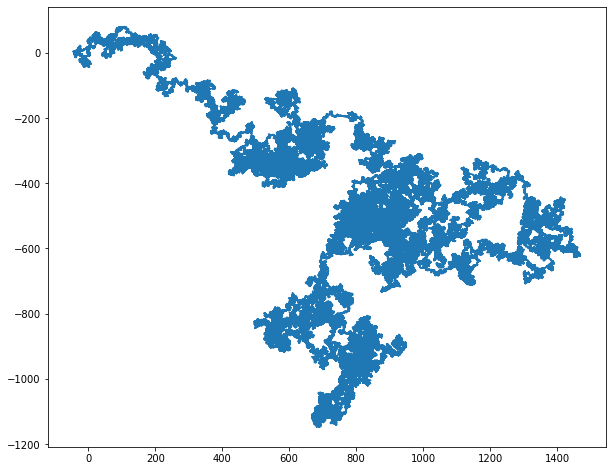

In [60]:
g = gen(np.array([0, 0]))
path = np.array([next(g) for k in range(1000000)])
x, y = path[:, 0], path[:, 1]

x_diam = x.max() - x.min()
y_diam = y.max() - y.min()
diam = max(x_diam, y_diam)

plt.figure(figsize=(x_diam / diam * 10, y_diam / diam * 10))
plt.gca().add_patch(plt.Circle((0, 0), 0.3, color='r'))
plt.plot(x, y)
plt.show()

In [56]:
len(set(map(tuple, path)))

382

In [61]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from itertools import product
from lightgbm import LGBMRegressor

def RMSE(series_true, series_predicted):
    return sum((series_true - series_predicted)**2 / len(series_true))**0.5

# Read data and change types

Here I read train and test tables which don't have lag features and features that are encoded via target encoding 

In [62]:
X_basic = pd.read_csv('data/X_without_lags_and_target_encoding.csv')
y_basic = pd.read_csv('data/y_without_lags_and_target_encoding.csv').item_cnt
X_test_basic = pd.read_csv('data/test_without_lags_and_target_encoding.csv')

In [63]:
X_basic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10913850 entries, 0 to 10913849
Data columns (total 9 columns):
 #   Column            Dtype
---  ------            -----
 0   date_block_num    int64
 1   shop_id           int64
 2   item_id           int64
 3   item_category_id  int64
 4   super_category    int64
 5   category          int64
 6   city              int64
 7   shop_type         int64
 8   shop_name         int64
dtypes: int64(9)
memory usage: 749.4 MB


**date_block_num** - the serial number of month since the January, 2013.  
**shop_id** - the id of shop. Ranges from 0 to 59.  
**item_id** - the id of item. Ranges from 0 to 22169.  
**item_category_id** - the id of category. Ranges from 0 to 83.  
  
All item categories are splitted into super and simple category.  
**super_category** - the id of super category. Ranges from 0 to 14.  
**category** - the id of simple category. Ranges from 0 to 66.  
  
All shop names contain the city, type and name of shops.  
**city** - the id of city. Ranges from 0 to 28.  
**shop_type** - the id of shop type. Ranges from 0 to 8.  
**shop_name** - the id of shop name. Ranges from 0 to 50.

The memory is relatively high. So I change the types of all the features.

In [64]:
types = {
    'date_block_num': 'int8',
    'shop_id': 'int8',
    'item_id': 'int16',
    'item_category_id': 'int8',
    'super_category': 'int8',
    'category': 'int8',
    'city': 'int8',
    'shop_type': 'int8',
    'shop_name': 'int8'
}

In [65]:
X_basic = X_basic.astype(types)
X_test_basic = X_test_basic.astype(types)

In [66]:
X_basic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10913850 entries, 0 to 10913849
Data columns (total 9 columns):
 #   Column            Dtype
---  ------            -----
 0   date_block_num    int8 
 1   shop_id           int8 
 2   item_id           int16
 3   item_category_id  int8 
 4   super_category    int8 
 5   category          int8 
 6   city              int8 
 7   shop_type         int8 
 8   shop_name         int8 
dtypes: int16(1), int8(8)
memory usage: 104.1 MB


As you can see the memory size has decreased by 7 times!

Creating the train and valid datasets.

In [67]:
X_train_basic = X_basic[X_basic.date_block_num < 33]
y_train_basic = y_basic[X_basic.date_block_num < 33]

X_val_basic = X_basic[X_basic.date_block_num == 33]
y_val_basic = y_basic[X_basic.date_block_num == 33]

Here I read train and test tables which have lag features but don't have features that are encoded via target encoding 

In [8]:
X_lags = pd.read_csv('data/X_without_target_encoding.csv')
y_lags = pd.read_csv('data/y_without_target_encoding.csv').item_cnt
X_test_lags = pd.read_csv('data/test_without_target_encoding.csv')

In [9]:
X_lags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6425094 entries, 0 to 6425093
Data columns (total 21 columns):
 #   Column            Dtype
---  ------            -----
 0   date_block_num    int64
 1   shop_id           int64
 2   item_id           int64
 3   item_category_id  int64
 4   super_category    int64
 5   category          int64
 6   city              int64
 7   shop_type         int64
 8   shop_name         int64
 9   item_cnt_lag1     int64
 10  item_cnt_lag2     int64
 11  item_cnt_lag3     int64
 12  item_cnt_lag4     int64
 13  item_cnt_lag5     int64
 14  item_cnt_lag6     int64
 15  item_cnt_lag7     int64
 16  item_cnt_lag8     int64
 17  item_cnt_lag9     int64
 18  item_cnt_lag10    int64
 19  item_cnt_lag11    int64
 20  item_cnt_lag12    int64
dtypes: int64(21)
memory usage: 1.0 GB


**item_cnt_lag{i}** for *i* from 1 to 12 is the value of **item_cnt** of the same row with **date_block_num** less on *i*.

As for previous tables, I will decrease the memory usage of this table. As first 8 features are also the features of the **X_basic** dataset, their new types are the same. So I just add new types for lag features.

In [10]:
types.update({
    f'item_cnt_lag{i}': 'int8' for i in range(1, 13)
})

In [11]:
X_lags = X_lags.astype(types)
X_test_lags = X_test_lags.astype(types)

In [12]:
X_lags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6425094 entries, 0 to 6425093
Data columns (total 21 columns):
 #   Column            Dtype
---  ------            -----
 0   date_block_num    int8 
 1   shop_id           int8 
 2   item_id           int16
 3   item_category_id  int8 
 4   super_category    int8 
 5   category          int8 
 6   city              int8 
 7   shop_type         int8 
 8   shop_name         int8 
 9   item_cnt_lag1     int8 
 10  item_cnt_lag2     int8 
 11  item_cnt_lag3     int8 
 12  item_cnt_lag4     int8 
 13  item_cnt_lag5     int8 
 14  item_cnt_lag6     int8 
 15  item_cnt_lag7     int8 
 16  item_cnt_lag8     int8 
 17  item_cnt_lag9     int8 
 18  item_cnt_lag10    int8 
 19  item_cnt_lag11    int8 
 20  item_cnt_lag12    int8 
dtypes: int16(1), int8(20)
memory usage: 134.8 MB


Creating the train and valid datasets.

In [13]:
X_train_lags = X_lags[X_lags.date_block_num < 33]
y_train_lags = y_lags[X_lags.date_block_num < 33]

X_val_lags = X_lags[X_lags.date_block_num == 33]
y_val_lags = y_lags[X_lags.date_block_num == 33]

Here I read train and test tables which have lag features and features that are encoded via target encoding 

In [40]:
X_full = pd.read_csv('data/X_full.csv')
y_full = pd.read_csv('data/y_full.csv').item_cnt
X_test_full = pd.read_csv('data/test_full.csv')

In [41]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6425094 entries, 0 to 6425093
Data columns (total 29 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   date_block_num            int64  
 1   shop_id                   int64  
 2   item_id                   int64  
 3   item_category_id          int64  
 4   super_category            int64  
 5   category                  int64  
 6   city                      int64  
 7   shop_type                 int64  
 8   shop_name                 int64  
 9   item_cnt_lag1             int64  
 10  item_cnt_lag2             int64  
 11  item_cnt_lag3             int64  
 12  item_cnt_lag4             int64  
 13  item_cnt_lag5             int64  
 14  item_cnt_lag6             int64  
 15  item_cnt_lag7             int64  
 16  item_cnt_lag8             int64  
 17  item_cnt_lag9             int64  
 18  item_cnt_lag10            int64  
 19  item_cnt_lag11            int64  
 20  item_cnt_lag12          

**encoded_{feature}** are encoded features using target encoding.

As for previous tables, I will decrease the memory usage of this table. As first 21 features are also the features of the **X_lags** dataset, their new types are the same. So I just add new types for encoded features.

In [42]:
types.update({
    col: 'float32' for col in X_full.columns[21:]
})

In [43]:
X_full = X_full.astype(types)
X_test_full = X_test_full.astype(types)

In [44]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6425094 entries, 0 to 6425093
Data columns (total 29 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   date_block_num            int8   
 1   shop_id                   int8   
 2   item_id                   int16  
 3   item_category_id          int8   
 4   super_category            int8   
 5   category                  int8   
 6   city                      int8   
 7   shop_type                 int8   
 8   shop_name                 int8   
 9   item_cnt_lag1             int8   
 10  item_cnt_lag2             int8   
 11  item_cnt_lag3             int8   
 12  item_cnt_lag4             int8   
 13  item_cnt_lag5             int8   
 14  item_cnt_lag6             int8   
 15  item_cnt_lag7             int8   
 16  item_cnt_lag8             int8   
 17  item_cnt_lag9             int8   
 18  item_cnt_lag10            int8   
 19  item_cnt_lag11            int8   
 20  item_cnt_lag12          

Creating the train and valid datasets.

In [45]:
X_train_full = X_full[X_full.date_block_num < 33]
y_train_full = y_full[X_full.date_block_num < 33]

X_val_full = X_full[X_full.date_block_num == 33]
y_val_full = y_full[X_full.date_block_num == 33]

Here I drop "unencoded" features - the features that was encoded.

In [58]:
X_full_reduced = X_full.drop(columns=X_full.columns[1:9])
y_full_reduced = y_full.copy()
X_test_full_reduced = X_test_full.drop(columns=X_test_full.columns[1:9])

Creating the train and valid datasets.

In [60]:
X_train_full_reduced = X_full_reduced[X_full_reduced.date_block_num < 33]
y_train_full_reduced = y_full_reduced[X_full_reduced.date_block_num < 33]

X_val_full_reduced = X_full_reduced[X_full_reduced.date_block_num == 33]
y_val_full_reduced = y_full_reduced[X_full_reduced.date_block_num == 33]

# Training models

I decided to use gradient boosting because it is the model that gives a high quality. I use lgbm because it is faster than simple gradient boosting or xgboost.

For 4 types of data I tune the **max_depth** parameter of lgbm. Also I use early stopping using validation dataset because it is more efficient than selection some value of the number of estimators. Then I plot the graphics of train and validation score from **max_depth** parameter and choose the values of this parameter which minimize the train score and the validation score.

## Data without lag features and target encoding

Training LGBM models with different values of max_depth

In [77]:
lgbm = LGBMRegressor(max_depth=2)
lgbm.fit(X_train_basic.drop(columns=['shop_id', 'item_id', 'item_category_id']),
         y_train_basic,
         eval_set=[(X_val_basic.drop(columns=['shop_id', 'item_id', 'item_category_id']), y_val_basic)],
         eval_metric='l2',
         early_stopping_rounds=20,
         verbose=10)

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's l2: 1.24836
[20]	valid_0's l2: 1.2432
[30]	valid_0's l2: 1.23873
[40]	valid_0's l2: 1.23266
[50]	valid_0's l2: 1.22563
[60]	valid_0's l2: 1.22183
[70]	valid_0's l2: 1.21757
[80]	valid_0's l2: 1.21272
[90]	valid_0's l2: 1.20433
[100]	valid_0's l2: 1.20063


LGBMRegressor(max_depth=2)

In [80]:
RMSE(y_val_basic, lgbm.predict(X_val_basic.drop(columns=['shop_id', 'item_id', 'item_category_id'])).clip(0, 20))

1.0957201142941546

In [79]:
list(zip(X_basic.drop(columns=['shop_id', 'item_id', 'item_category_id']).columns, lgbm.feature_importances_))

[('date_block_num', 19),
 ('super_category', 47),
 ('category', 106),
 ('city', 60),
 ('shop_type', 21),
 ('shop_name', 47)]

In [76]:
list(zip(X_basic.columns, lgbm.feature_importances_))

[('date_block_num', 19),
 ('shop_id', 55),
 ('item_id', 9),
 ('item_category_id', 77),
 ('super_category', 6),
 ('category', 61),
 ('city', 28),
 ('shop_type', 11),
 ('shop_name', 31)]

In [20]:
lgbm_train_basic_rmses = {}
lgbm_val_basic_rmses = {}
best_iterations_basic = {}
max_depths = range(1, 30)
for max_depth in max_depths:
    start = datetime.datetime.now()
    print('max_depth:', max_depth)
    lgbm = LGBMRegressor(max_depth=max_depth)
    lgbm.fit(X_train_basic,
             y_train_basic,
             eval_set=[(X_val_basic, y_val_basic)],
             eval_metric='l2',
             early_stopping_rounds=20,
             verbose=10)
    best_iterations_basic[max_depth] = lgbm.best_iteration_
    lgbm_train_basic_rmses[max_depth] = RMSE(y_train_basic, lgbm.predict(X_train_basic).clip(0, 20))
    lgbm_val_basic_rmses[max_depth] = RMSE(y_val_basic, lgbm.predict(X_val_basic).clip(0, 20))
    print('train RMSE:', lgbm_train_basic_rmses[max_depth], ' | ',
          'val RMSE:', lgbm_val_basic_rmses[max_depth])
    print('Evaluation time:', datetime.datetime.now() - start)
    print('------------------------------------------------------')

max_depth: 1


c:\users\user\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's l2: 1.26053
[20]	valid_0's l2: 1.25568
[30]	valid_0's l2: 1.25299
[40]	valid_0's l2: 1.25116
[50]	valid_0's l2: 1.24925
[60]	valid_0's l2: 1.24793
[70]	valid_0's l2: 1.24568
[80]	valid_0's l2: 1.24491
[90]	valid_0's l2: 1.24348
[100]	valid_0's l2: 1.24258
train RMSE: 1.189269057903918  |  val RMSE: 1.114703750989341
Evaluation time: 0:01:07.538141
------------------------------------------------------
max_depth: 2
[10]	valid_0's l2: 1.24964
[20]	valid_0's l2: 1.24161
[30]	valid_0's l2: 1.23557
[40]	valid_0's l2: 1.22783
[50]	valid_0's l2: 1.21805
[60]	valid_0's l2: 1.20756
[70]	valid_0's l2: 1.19576
[80]	valid_0's l2: 1.18824
[90]	valid_0's l2: 1.17906
[100]	valid_0's l2: 1.17827
train RMSE: 1.1647516888667555  |  val RMSE: 1.0854664080163805
Evaluation time: 0:01:22.521754
------------------------------------------------------
max_depth: 3
[10]	valid_0's l2: 1.23995
[20]	valid_0's l2: 1.22781
[30]	valid_0's l2: 1.21538
[40]	valid_0's l2: 1.19735
[50]	valid_0's l2: 1.177

[10]	valid_0's l2: 1.16972
[20]	valid_0's l2: 1.13682
[30]	valid_0's l2: 1.1265
[40]	valid_0's l2: 1.10841
[50]	valid_0's l2: 1.10016
[60]	valid_0's l2: 1.09153
[70]	valid_0's l2: 1.08669
[80]	valid_0's l2: 1.0811
[90]	valid_0's l2: 1.07661
[100]	valid_0's l2: 1.06812
train RMSE: 1.102108682836578  |  val RMSE: 1.0334697428101804
Evaluation time: 0:02:01.057225
------------------------------------------------------
max_depth: 21
[10]	valid_0's l2: 1.16972
[20]	valid_0's l2: 1.13682
[30]	valid_0's l2: 1.1265
[40]	valid_0's l2: 1.10841
[50]	valid_0's l2: 1.10016
[60]	valid_0's l2: 1.09153
[70]	valid_0's l2: 1.08669
[80]	valid_0's l2: 1.0811
[90]	valid_0's l2: 1.07661
[100]	valid_0's l2: 1.06812
train RMSE: 1.102108682836578  |  val RMSE: 1.0334697428101804
Evaluation time: 0:02:00.887285
------------------------------------------------------
max_depth: 22
[10]	valid_0's l2: 1.16972
[20]	valid_0's l2: 1.13682
[30]	valid_0's l2: 1.1265
[40]	valid_0's l2: 1.10841
[50]	valid_0's l2: 1.10016


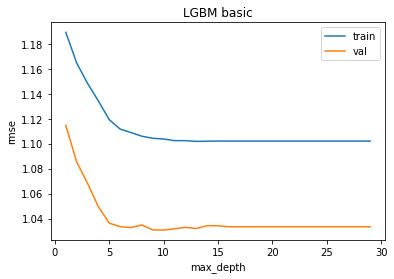

In [21]:
plt.title('LGBM basic')
plt.plot(max_depths, lgbm_train_basic_rmses.values())
plt.plot(max_depths, lgbm_val_basic_rmses.values())
plt.legend(['train', 'val'])
plt.xlabel('max_depth')
plt.ylabel('rmse')
plt.show()

The maximum depths of the best lgbm models according to train or validate mse

In [22]:
lgbm_train_basic_rmses = np.array(list(lgbm_train_basic_rmses.values()))
lgbm_val_basic_rmses = np.array(list(lgbm_val_basic_rmses.values()))

print('max depth according to train rmse:', max_depths[lgbm_train_basic_rmses.argmin()])
print('max depth according to val rmse:', max_depths[lgbm_val_basic_rmses.argmin()])

max depth according to train rmse: 13
max depth according to val rmse: 10


For max depth equals 10 the rmse's are:  
train RMSE: 1.10380  |  val RMSE: 1.03086  
For max depth equals 13 the rmse's are:  
train RMSE: 1.10188  |  val RMSE: 1.03205

## Data with lag features but without target encoding

In [23]:
lgbm_train_lags_rmses = {}
lgbm_val_lags_rmses = {}
best_iterations_lags = {}
max_depths = range(1, 30)
for max_depth in max_depths:
    start = datetime.datetime.now()
    print('max_depth:', max_depth)
    lgbm = LGBMRegressor(max_depth=max_depth)
    lgbm.fit(X_train_lags,
             y_train_lags,
             eval_set=[(X_val_lags, y_val_lags)],
             eval_metric='l2',
             early_stopping_rounds=20,
             verbose=10)
    best_iterations_lags[max_depth] = lgbm.best_iteration_
    lgbm_train_lags_rmses[max_depth] = RMSE(y_train_lags, lgbm.predict(X_train_lags).clip(0, 20))
    lgbm_val_lags_rmses[max_depth] = RMSE(y_val_lags, lgbm.predict(X_val_lags).clip(0, 20))
    print('train RMSE:', lgbm_train_lags_rmses[max_depth], ' | ',
          'val RMSE:', lgbm_val_lags_rmses[max_depth])
    print('Evaluation time:', datetime.datetime.now() - start)
    print('------------------------------------------------------')

max_depth: 1
[10]	valid_0's l2: 1.077
[20]	valid_0's l2: 1.01215
[30]	valid_0's l2: 0.983657
[40]	valid_0's l2: 0.968926
[50]	valid_0's l2: 0.959526
[60]	valid_0's l2: 0.953576
[70]	valid_0's l2: 0.94962
[80]	valid_0's l2: 0.946364
[90]	valid_0's l2: 0.944301
[100]	valid_0's l2: 0.942641
train RMSE: 0.9333920434895312  |  val RMSE: 0.9708972245567559
Evaluation time: 0:00:51.636278
------------------------------------------------------
max_depth: 2
[10]	valid_0's l2: 1.01926
[20]	valid_0's l2: 0.963583
[30]	valid_0's l2: 0.94479
[40]	valid_0's l2: 0.938376
[50]	valid_0's l2: 0.935242
[60]	valid_0's l2: 0.9331
[70]	valid_0's l2: 0.931623
[80]	valid_0's l2: 0.929324
[90]	valid_0's l2: 0.926933
[100]	valid_0's l2: 0.92314
train RMSE: 0.9222783565323427  |  val RMSE: 0.9608016201525409
Evaluation time: 0:00:56.293821
------------------------------------------------------
max_depth: 3
[10]	valid_0's l2: 0.992964
[20]	valid_0's l2: 0.945835
[30]	valid_0's l2: 0.934558
[40]	valid_0's l2: 0.93

[80]	valid_0's l2: 0.893113
[90]	valid_0's l2: 0.888604
[100]	valid_0's l2: 0.886321
train RMSE: 0.8769934645174721  |  val RMSE: 0.941037465998777
Evaluation time: 0:01:22.761338
------------------------------------------------------
max_depth: 20
[10]	valid_0's l2: 0.970452
[20]	valid_0's l2: 0.927899
[30]	valid_0's l2: 0.918143
[40]	valid_0's l2: 0.91081
[50]	valid_0's l2: 0.90721
[60]	valid_0's l2: 0.89641
[70]	valid_0's l2: 0.889441
[80]	valid_0's l2: 0.885592
[90]	valid_0's l2: 0.884454
[100]	valid_0's l2: 0.884591
train RMSE: 0.8801624368858316  |  val RMSE: 0.9400738102386127
Evaluation time: 0:01:20.409662
------------------------------------------------------
max_depth: 21
[10]	valid_0's l2: 0.970452
[20]	valid_0's l2: 0.927899
[30]	valid_0's l2: 0.918143
[40]	valid_0's l2: 0.91081
[50]	valid_0's l2: 0.90721
[60]	valid_0's l2: 0.896287
[70]	valid_0's l2: 0.889537
[80]	valid_0's l2: 0.88722
[90]	valid_0's l2: 0.885942
[100]	valid_0's l2: 0.88925
train RMSE: 0.8777476698497476 

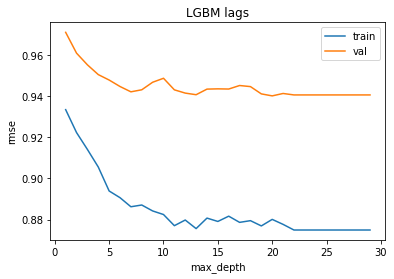

In [24]:
plt.title('LGBM lags')
plt.plot(max_depths, lgbm_train_lags_rmses.values())
plt.plot(max_depths, lgbm_val_lags_rmses.values())
plt.legend(['train', 'val'])
plt.xlabel('max_depth')
plt.ylabel('rmse')
plt.show()

In [25]:
lgbm_train_lags_rmses = np.array(list(lgbm_train_lags_rmses.values()))
lgbm_val_lags_rmses = np.array(list(lgbm_val_lags_rmses.values()))

print('max depth according to train rmse:', max_depths[lgbm_train_lags_rmses.argmin()])
print('max depth according to val rmse:', max_depths[lgbm_val_lags_rmses.argmin()])

max depth according to train rmse: 22
max depth according to val rmse: 20


For max depth equals 20 the rmse's are:  
train RMSE: 0.88016  |  val RMSE: 0.94007  
For max depth equals 22 the rmse's are:  
train RMSE: 0.87501  |  val RMSE: 0.94053

The quality is better than without lag features. It means that they help for predicting.

## Data with lag features and target encoding

In [46]:
lgbm_train_full_rmses = {}
lgbm_val_full_rmses = {}
best_iterations_full = {}
max_depths = range(1, 30)
for max_depth in max_depths:
    start = datetime.datetime.now()
    print('max_depth:', max_depth)
    lgbm = LGBMRegressor(max_depth=max_depth)
    lgbm.fit(X_train_full,
             y_train_full,
             eval_set=[(X_val_full, y_val_full)],
             eval_metric='l2',
             early_stopping_rounds=20,
             verbose=10)
    best_iterations_full[max_depth] = lgbm.best_iteration_
    lgbm_train_full_rmses[max_depth] = RMSE(y_train_full, lgbm.predict(X_train_full).clip(0, 20))
    lgbm_val_full_rmses[max_depth] = RMSE(y_val_full, lgbm.predict(X_val_full).clip(0, 20))
    print('train RMSE:', lgbm_train_full_rmses[max_depth], ' | ',
          'val RMSE:', lgbm_val_full_rmses[max_depth])
    print('Evaluation time:', datetime.datetime.now() - start)
    print('------------------------------------------------------')

max_depth: 1


c:\users\user\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's l2: 1.05804
[20]	valid_0's l2: 0.97222
[30]	valid_0's l2: 0.935631
[40]	valid_0's l2: 0.91928
[50]	valid_0's l2: 0.912208
[60]	valid_0's l2: 0.910027
[70]	valid_0's l2: 0.906265
[80]	valid_0's l2: 0.905566
[90]	valid_0's l2: 0.903546
[100]	valid_0's l2: 0.902194
train RMSE: 0.9015515552342537  |  val RMSE: 0.949829759662076
Evaluation time: 0:01:00.484080
------------------------------------------------------
max_depth: 2
[10]	valid_0's l2: 0.980616
[20]	valid_0's l2: 0.90725
[30]	valid_0's l2: 0.889468
[40]	valid_0's l2: 0.877867
[50]	valid_0's l2: 0.866671
[60]	valid_0's l2: 0.861197
[70]	valid_0's l2: 0.855438
[80]	valid_0's l2: 0.851868
[90]	valid_0's l2: 0.84923
[100]	valid_0's l2: 0.846868
train RMSE: 0.8739489117971887  |  val RMSE: 0.9200841244738556
Evaluation time: 0:01:07.887882
------------------------------------------------------
max_depth: 3
[10]	valid_0's l2: 0.933016
[20]	valid_0's l2: 0.864749
[30]	valid_0's l2: 0.840662
[40]	valid_0's l2: 0.831254
[50]

[10]	valid_0's l2: 0.823434
[20]	valid_0's l2: 0.761412
[30]	valid_0's l2: 0.741481
[40]	valid_0's l2: 0.72801
[50]	valid_0's l2: 0.726246
[60]	valid_0's l2: 0.720945
[70]	valid_0's l2: 0.716627
[80]	valid_0's l2: 0.714391
[90]	valid_0's l2: 0.712963
[100]	valid_0's l2: 0.710092
train RMSE: 0.7631245102416568  |  val RMSE: 0.84265848968965
Evaluation time: 0:01:23.094939
------------------------------------------------------
max_depth: 21
[10]	valid_0's l2: 0.823434
[20]	valid_0's l2: 0.761412
[30]	valid_0's l2: 0.741481
[40]	valid_0's l2: 0.72801
[50]	valid_0's l2: 0.726246
[60]	valid_0's l2: 0.720239
[70]	valid_0's l2: 0.715295
[80]	valid_0's l2: 0.711426
[90]	valid_0's l2: 0.710662
[100]	valid_0's l2: 0.710429
train RMSE: 0.7696939245014939  |  val RMSE: 0.8426296654543233
Evaluation time: 0:01:19.998603
------------------------------------------------------
max_depth: 22
[10]	valid_0's l2: 0.823434
[20]	valid_0's l2: 0.761412
[30]	valid_0's l2: 0.741481
[40]	valid_0's l2: 0.72801
[

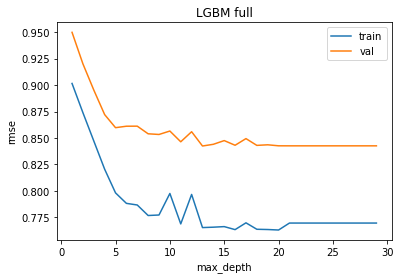

In [47]:
plt.title('LGBM full')
plt.plot(max_depths, lgbm_train_full_rmses.values())
plt.plot(max_depths, lgbm_val_full_rmses.values())
plt.legend(['train', 'val'])
plt.xlabel('max_depth')
plt.ylabel('rmse')
plt.show()

In [48]:
lgbm_train_full_rmses = np.array(list(lgbm_train_full_rmses.values()))
lgbm_val_full_rmses = np.array(list(lgbm_val_full_rmses.values()))

print('max depth according to train rmse:', max_depths[lgbm_train_full_rmses.argmin()])
print('max depth according to val rmse:', max_depths[lgbm_val_full_rmses.argmin()])

max depth according to train rmse: 20
max depth according to val rmse: 13


For max depth equals 13 the rmse's are:  
train RMSE: 0.76542  |  val RMSE: 0.84246  
For max depth equals 20 the rmse's are:  
train RMSE: 0.76312  |  val RMSE: 0.84266

The quality is better than without target encoded features. It means that they help for predicting.

##  Data with lag features and only target encoded features

In [82]:
lgbm_train_full_reduced_rmses = {}
lgbm_val_full_reduced_rmses = {}
best_iterations_full_reduced = {}
max_depths = range(1, 30)
for max_depth in max_depths:
    start = datetime.datetime.now()
    print('max_depth:', max_depth)
    lgbm = LGBMRegressor(max_depth=max_depth)
    lgbm.fit(X_train_full_reduced,
             y_train_full_reduced,
             eval_set=[(X_val_full_reduced, y_val_full_reduced)],
             eval_metric='l2',
             early_stopping_rounds=20,
             verbose=10)
    best_iterations_full_reduced[max_depth] = lgbm.best_iteration_
    lgbm_train_full_reduced_rmses[max_depth] = RMSE(y_train_full_reduced, lgbm.predict(X_train_full_reduced).clip(0, 20))
    lgbm_val_full_reduced_rmses[max_depth] = RMSE(y_val_full_reduced, lgbm.predict(X_val_full_reduced).clip(0, 20))
    print('train RMSE:', lgbm_train_full_reduced_rmses[max_depth], ' | ',
          'val RMSE:', lgbm_val_full_reduced_rmses[max_depth])
    print('Evaluation time:', datetime.datetime.now() - start)
    print('------------------------------------------------------')

max_depth: 1


c:\users\user\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\users\user\appdata\local\programs\python\python39\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	valid_0's l2: 1.05804
[20]	valid_0's l2: 0.97222
[30]	valid_0's l2: 0.935631
[40]	valid_0's l2: 0.91928
[50]	valid_0's l2: 0.912208
[60]	valid_0's l2: 0.910027
[70]	valid_0's l2: 0.906265
[80]	valid_0's l2: 0.905566
[90]	valid_0's l2: 0.903546
[100]	valid_0's l2: 0.902194
train RMSE: 0.9015515552342537  |  val RMSE: 0.949829759662076
Evaluation time: 0:00:50.611071
------------------------------------------------------
max_depth: 2
[10]	valid_0's l2: 0.980616
[20]	valid_0's l2: 0.90725
[30]	valid_0's l2: 0.890272
[40]	valid_0's l2: 0.87963
[50]	valid_0's l2: 0.869829
[60]	valid_0's l2: 0.86423
[70]	valid_0's l2: 0.858207
[80]	valid_0's l2: 0.854594
[90]	valid_0's l2: 0.851638
[100]	valid_0's l2: 0.849312
train RMSE: 0.8743863241820032  |  val RMSE: 0.9214334360154242
Evaluation time: 0:01:01.243210
------------------------------------------------------
max_depth: 3
[10]	valid_0's l2: 0.93348
[20]	valid_0's l2: 0.867095
[30]	valid_0's l2: 0.843247
[40]	valid_0's l2: 0.833828
[50]	v

[90]	valid_0's l2: 0.724226
[100]	valid_0's l2: 0.724861
train RMSE: 0.7747109374263759  |  val RMSE: 0.8505572328752603
Evaluation time: 0:01:15.365801
------------------------------------------------------
max_depth: 20
[10]	valid_0's l2: 0.830415
[20]	valid_0's l2: 0.77165
[30]	valid_0's l2: 0.751589
[40]	valid_0's l2: 0.742157
[50]	valid_0's l2: 0.741179
[60]	valid_0's l2: 0.734239
[70]	valid_0's l2: 0.728211
[80]	valid_0's l2: 0.725518
[90]	valid_0's l2: 0.724226
[100]	valid_0's l2: 0.724861
train RMSE: 0.7747109374263759  |  val RMSE: 0.8505572328752603
Evaluation time: 0:01:11.395628
------------------------------------------------------
max_depth: 21
[10]	valid_0's l2: 0.830415
[20]	valid_0's l2: 0.77165
[30]	valid_0's l2: 0.751589
[40]	valid_0's l2: 0.742157
[50]	valid_0's l2: 0.741179
[60]	valid_0's l2: 0.734239
[70]	valid_0's l2: 0.728211
[80]	valid_0's l2: 0.725518
[90]	valid_0's l2: 0.724226
[100]	valid_0's l2: 0.724861
train RMSE: 0.7747109374263759  |  val RMSE: 0.850557

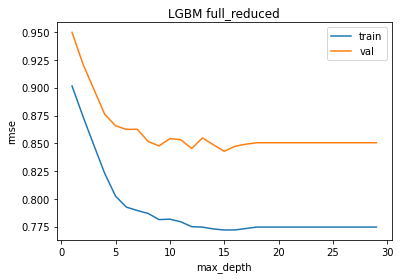

In [83]:
plt.title('LGBM full_reduced')
plt.plot(max_depths, lgbm_train_full_reduced_rmses.values())
plt.plot(max_depths, lgbm_val_full_reduced_rmses.values())
plt.legend(['train', 'val'])
plt.xlabel('max_depth')
plt.ylabel('rmse')
plt.show()

In [84]:
lgbm_train_full_reduced_rmses = np.array(list(lgbm_train_full_reduced_rmses.values()))
lgbm_val_full_reduced_rmses = np.array(list(lgbm_val_full_reduced_rmses.values()))

print('max depth according to train rmse:', max_depths[lgbm_train_full_reduced_rmses.argmin()])
print('max depth according to val rmse:', max_depths[lgbm_val_full_reduced_rmses.argmin()])

max depth according to train rmse: 15
max depth according to val rmse: 15


For max depth equals 15 the rmse's are:  
train RMSE: 0.77206  |  val RMSE: 0.84288

The quality is worse than with all the features. Maybe because the number of features is less than earlier.

# Submission

In [29]:
import glob
import re

def submit(y_predicted):
    my_submissions_paths = glob.glob('./data/my_submission_*.csv')
    nums = [int(re.findall(r'\d+', filepath)[0]) for filepath in my_submissions_paths]
    n = max(nums) + 1
    submission = pd.read_csv('data/sample_submission.csv')
    submission.item_cnt_month = y_predicted
    submission.to_csv(f'data/my_submission_{n}.csv', index=None)
    return f'data/my_submission_{n}.csv'

For all previous cases I will submit the results just to see the full result of training.  
Also in all cases I choose the **max_depth** parameter that minimizes the score on validation dataset.  
As I saved all best iterations to variables *best_iterations_\{basic|lags|full\}* I will use it to set the **n_estimators** parameter.

I forgot that the test datasets contain the ID column so I drop it only here.

In [33]:
X_test_basic.drop(columns='ID', inplace=True)
X_test_lags.drop(columns='ID', inplace=True)
X_test_full.drop(columns='ID', inplace=True)

## Data without lag features and target encoding

In [34]:
best_max_depth = 10
best_n_estimators = best_iterations_basic[best_max_depth]

best_lgbm = LGBMRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth
)
best_lgbm.fit(X_basic, y_basic)

submit(best_lgbm.predict(X_test_basic).clip(0, 20))

'data/my_submission_20.csv'

SCORE = 1.10421

## Data with lag features but without target encoding

In [35]:
best_max_depth = 20
best_n_estimators = best_iterations_lags[best_max_depth]

best_lgbm = LGBMRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth
)
best_lgbm.fit(X_lags, y_lags)

submit(best_lgbm.predict(X_test_lags).clip(0, 20))

'data/my_submission_21.csv'

SCORE = 1.00936

The score is lower than in previous case. It means that lag features help for predicting.  

## Data with lag features and target encoding

In [52]:
best_max_depth = 13
best_n_estimators = best_iterations_full[best_max_depth]

best_lgbm = LGBMRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth
)
best_lgbm.fit(X_full, y_full)

submit(best_lgbm.predict(X_test_full).clip(0, 20))

'data/my_submission_22.csv'

SCORE = 1.02926

The score is higher than in previous case. It is very strange because the train and validation scores are lower than for data without target encoded features.

## Data with lag features and only target encoded features

In [85]:
best_max_depth = 15
best_n_estimators = best_iterations_full_reduced[best_max_depth]

best_lgbm = LGBMRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth
)
best_lgbm.fit(X_train_full_reduced, y_train_full_reduced)

submit(best_lgbm.predict(X_test_full_reduced).clip(0, 20))

'data/my_submission_23.csv'

SCORE = 1.04886

The score is higher than in previous case. It might mean that target encoded features don't help for predicting. But it was impossible to predict this fact according to training and checking the quality on validation dataset.  
Also it might be an overfitting. But almost all the graphics of train and validation scores are the same: val score is higher.  
So I don't know the reason of these high scores for sure.  
The best model is lgbm for data only with lag features.